In [1]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from collections import OrderedDict

from models import AlexNet, XAlexNet, vgg16, xvgg16, fixup_resnet50, xfixup_resnet50
from utils.visualization import visualize_attrs, show_img, pil_img
from captum.attr import InputXGradient, IntegratedGradients

# Load models

In [2]:
torch.manual_seed(4)
device = "cuda:0"

model_type = 'vgg16' # SET THIS TO THE MODEL YOU WANT TO USE
model_dict = '/data/rhesse/imagenet_models/' # SET THIS TO THE PATH OF YOUR MODELS

# create models...
if model_type == 'alexnet':
    model = AlexNet().to(device)
    checkpoint = torch.load(model_dict + 'alexnet_model_best.pth.tar', map_location=device)
    xmodel = XAlexNet().to(device)
    xcheckpoint = torch.load(model_dict + 'xalexnet_model_best.pth.tar', map_location=device)
elif model_type == 'resnet50':
    model = fixup_resnet50().to(device)
    checkpoint = torch.load(model_dict + 'fixup_resnet50_model_best.pth.tar', map_location=device)
    xmodel = xfixup_resnet50().to(device)
    xcheckpoint = torch.load(model_dict + 'xfixup_resnet50_model_best.pth.tar', map_location=device)
elif model_type == 'vgg16':
    model = vgg16().to(device)
    checkpoint = torch.load(model_dict + 'vgg16_model_best.pth.tar', map_location=device)
    xmodel = xvgg16().to(device)
    xcheckpoint = torch.load(model_dict + 'xvgg16_model_best.pth.tar', map_location=device)

#remove preceding module. because it was stored as DataParallel
state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k[:7] == 'module.':
        name = k[7:]  # remove 'module.'
    else:
        name = k
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

state_dict = xcheckpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k[:7] == 'module.':
        name = k[7:]  # remove 'module.'
    else:
        name = k
    new_state_dict[name] = v
xmodel.load_state_dict(new_state_dict)

model.eval()
xmodel.eval()

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transf = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])

denormalize = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

out_dir = "/data/rhesse/attr_vis/"

# Visualize Attribution for Normal Images

1eb9afc2b4e01ecd.jpg


Input Tensor 0 did not already require gradients, required_grads has been set automatically.


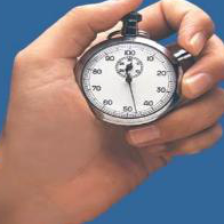

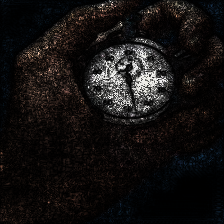

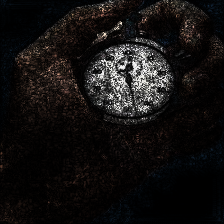

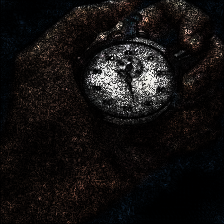

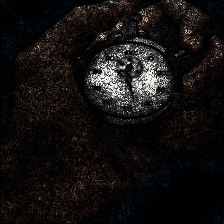

tensor([826], device='cuda:0')
700a04c5c2ca6e80.jpg


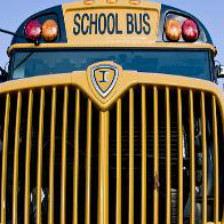

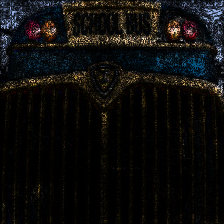

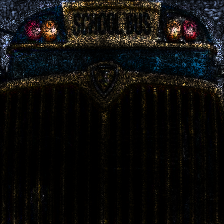

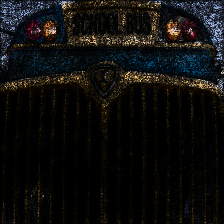

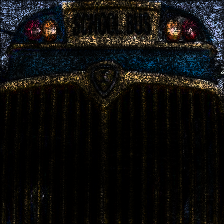

tensor([779], device='cuda:0')
70bfca4555cca92e.jpg


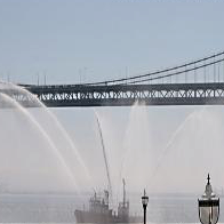

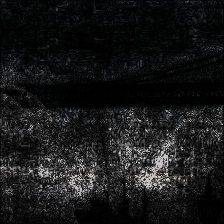

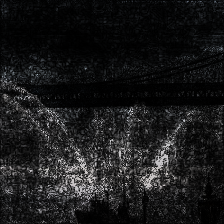

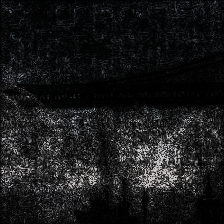

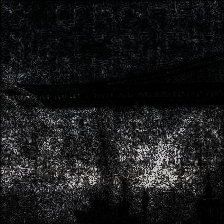

tensor([554], device='cuda:0')
80c64f2e27f8784a.jpg


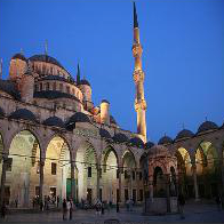

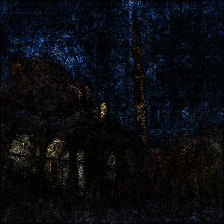

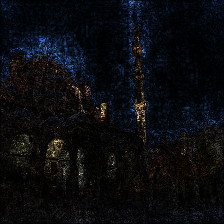

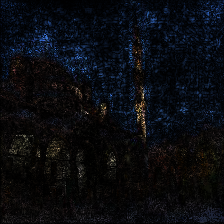

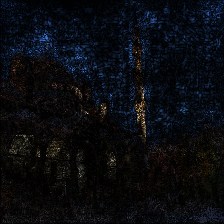

tensor([668], device='cuda:0')
87fa4cf351b87562.jpg


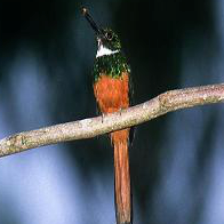

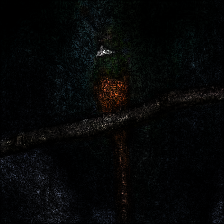

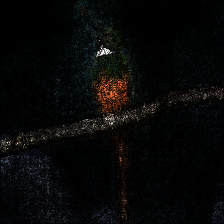

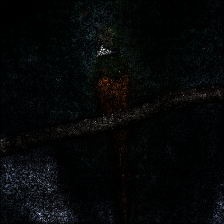

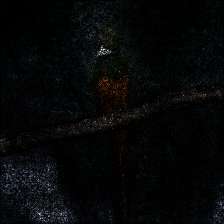

tensor([95], device='cuda:0')
8e570672510267d3.jpg


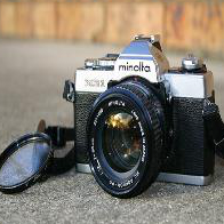

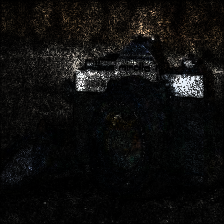

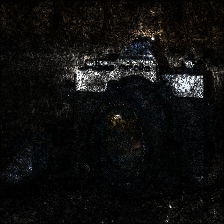

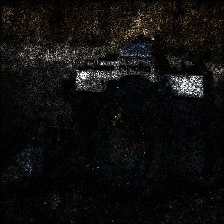

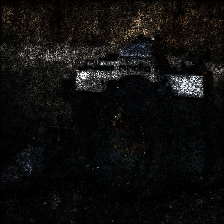

tensor([759], device='cuda:0')
9a7e268c95022a1c.jpg


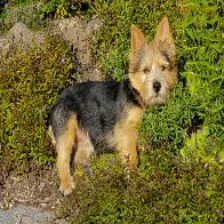

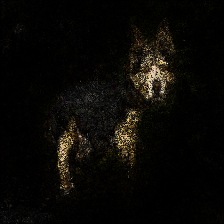

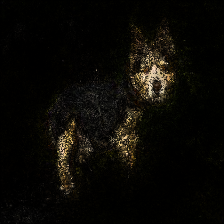

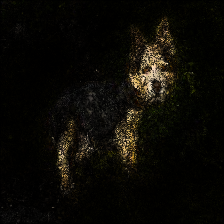

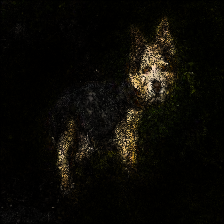

tensor([189], device='cuda:0')
f33412087d9c224e.jpg


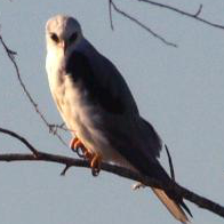

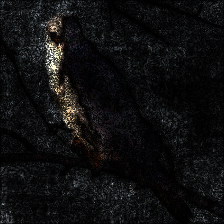

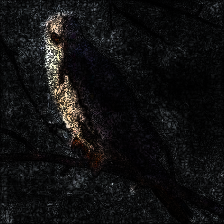

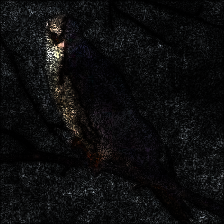

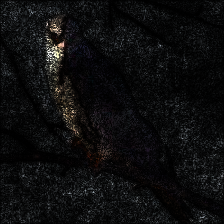

tensor([21], device='cuda:0')


In [3]:
for filename in os.listdir('./images'):

    if filename.endswith(".jpeg") or filename.endswith(".jpg"): 
        print(filename)
        if filename == "9a7e268c95022a1c.jpg":
            correct_class = 189
        elif filename == "87fa4cf351b87562.jpg":
            correct_class = 95
        elif filename == "70bfca4555cca92e.jpg":
            correct_class = 554
        elif filename == "700a04c5c2ca6e80.jpg":
            correct_class = 779
        elif filename == "f33412087d9c224e.jpg":
            correct_class = 21
        elif filename == "80c64f2e27f8784a.jpg":
            correct_class = 668
        elif filename == "1eb9afc2b4e01ecd.jpg":
            correct_class = 826
        elif filename == "8e570672510267d3.jpg":
            correct_class = 759
        else:
            assert 0==1
        img_pil = Image.open("./images/" + filename)
        
        input = transf(img_pil).unsqueeze(0).to(device)

        correct_class = torch.tensor([correct_class]).to(device)

        ixg = InputXGradient(model)
        attributions = ixg.attribute(input, target=correct_class)

        ig = IntegratedGradients(model, multiply_by_inputs=True)
        baseline = torch.zeros(input.shape).to(device)
        attributions_ig = ig.attribute(input,
                                         baseline,
                                         target=correct_class,
                                         method='gausslegendre',
                                         return_convergence_delta=False,
                                         n_steps = 128)
        
        attributions = attributions.detach().squeeze(0).permute(1,2,0).cpu().numpy()
        attributions_ig = attributions_ig.detach().squeeze(0).permute(1,2,0).cpu().numpy()
        
        xg = InputXGradient(xmodel)
        xattributions = xg.attribute(input, target=correct_class)

        ig_x = IntegratedGradients(xmodel, multiply_by_inputs=True)
        baseline = torch.zeros(input.shape).to(device)
        xattributions_ig = ig_x.attribute(input,
                                         baseline,
                                         target=correct_class,
                                         method='gausslegendre',
                                         return_convergence_delta=False,
                                         n_steps = 128)

        xattributions = xattributions.detach().squeeze(0).permute(1,2,0).cpu().numpy()
        xattributions_ig = xattributions_ig.detach().squeeze(0).permute(1,2,0).cpu().numpy()

        
        img = transf(img_pil)
        img = denormalize(img).permute(1,2,0).numpy()*255.

        show_img(pil_img(img), out_dir=out_dir, name=str(correct_class.item())+'_normal.png')
        visualize_attrs(img, attributions, out_dir=out_dir, name=str(correct_class.item())+'_ixg_normal.png')
        visualize_attrs(img, attributions_ig, out_dir=out_dir, name=str(correct_class.item())+'_ig_normal.png')
        visualize_attrs(img, xattributions, out_dir=out_dir, name=str(correct_class.item())+'_xg_normal.png')
        visualize_attrs(img, xattributions_ig, out_dir=out_dir, name=str(correct_class.item())+'_xig_normal.png')
        
        
        print(correct_class)
        
    else:
        continue

# Visualize Attribution for Contrast Reduced Images

In [4]:
for filename in os.listdir('./images'):

    if filename.endswith(".jpeg") or filename.endswith(".jpg"): 
        print(filename)
        if filename == "9a7e268c95022a1c.jpg":
            correct_class = 189
        elif filename == "87fa4cf351b87562.jpg":
            correct_class = 95
        elif filename == "70bfca4555cca92e.jpg":
            correct_class = 554
        elif filename == "700a04c5c2ca6e80.jpg":
            correct_class = 779
        elif filename == "f33412087d9c224e.jpg":
            correct_class = 21
        elif filename == "80c64f2e27f8784a.jpg":
            correct_class = 668
        elif filename == "1eb9afc2b4e01ecd.jpg":
            correct_class = 826
        elif filename == "8e570672510267d3.jpg":
            correct_class = 759
        else:
            assert 0==1
        img_pil = Image.open("./images/" + filename)
        
        input = transf(img_pil).unsqueeze(0).to(device)*0.3
   
        correct_class = torch.tensor([correct_class]).to(device)
        
        ixg = InputXGradient(model)
        attributions = ixg.attribute(input, target=correct_class)

        ig = IntegratedGradients(model, multiply_by_inputs=True)
        baseline = torch.zeros(input.shape).to(device)
        attributions_ig = ig.attribute(input,
                                         baseline,
                                         target=correct_class,
                                         method='gausslegendre',
                                         return_convergence_delta=False,
                                         n_steps = 128)
        
        attributions = attributions.detach().squeeze(0).permute(1,2,0).cpu().numpy()
        attributions_ig = attributions_ig.detach().squeeze(0).permute(1,2,0).cpu().numpy()
        
        xg = InputXGradient(xmodel)
        xattributions = xg.attribute(input, target=correct_class)

        ig_x = IntegratedGradients(xmodel, multiply_by_inputs=True)
        baseline = torch.zeros(input.shape).to(device)
        xattributions_ig = ig_x.attribute(input,
                                         baseline,
                                         target=correct_class,
                                         method='gausslegendre',
                                         return_convergence_delta=False,
                                         n_steps = 128)

        xattributions = xattributions.detach().squeeze(0).permute(1,2,0).cpu().numpy()
        xattributions_ig = xattributions_ig.detach().squeeze(0).permute(1,2,0).cpu().numpy()

        
        img = transf(img_pil)*0.3
        img = denormalize(img).permute(1,2,0).numpy()*255.
        
        img_normal = transf(img_pil)
        img_normal = denormalize(img_normal).permute(1,2,0).numpy()*255.
        show_img(pil_img(img), out_dir=out_dir, name = str(correct_class.item()) + '_contrast.png')
        visualize_attrs(img_normal, attributions, out_dir=out_dir, name=str(correct_class.item())+'_ixg_contrast.png')
        visualize_attrs(img_normal, attributions_ig, out_dir=out_dir, name=str(correct_class.item())+'_ig_contrast.png')
        visualize_attrs(img_normal, xattributions, out_dir=out_dir, name=str(correct_class.item())+'_xg_contrast.png')
        visualize_attrs(img_normal, xattributions_ig, out_dir=out_dir, name=str(correct_class.item())+'_xig_contrast.png')
        
        print(correct_class)
        
    else:
        continue

1eb9afc2b4e01ecd.jpg


NameError: name 'pil_image' is not defined